In [1]:
from sklearn import mixture

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from tqdm import tqdm

import anndata as ad
import gc

# Functions to get and prepare data

In [4]:
def select_idx(idx_initial, percentage):

    # Number of data points to be selected
    n_selected = np.round(idx_initial.shape[0]*percentage).astype(int)
    # Select percentage% indexes randomly
    rng = np.random.default_rng()
    chosen_idx = rng.choice(idx_initial, n_selected, replace=False)
    # Not selected indexes
    excluded_idx = np.setdiff1d(idx_initial, chosen_idx)
    
    return chosen_idx, excluded_idx

In [5]:
def split_sample(onehot_genotype, p_train, p_val):
    idx_all = np.where(onehot_genotype==1)[0]
    train_idx, other_idx = select_idx(idx_all, p_train)
    val_idx, test_idx = select_idx(other_idx, p_val/(1-p_train))
    return train_idx, val_idx, test_idx

In [6]:
def dataset_split(hom_alt, hom_ref, het, expression, p_train=0.7, p_val=0.2): # 70% 20% 10% split
    
    # Split data for each genotype separatly
    train_hom_alt, val_hom_alt, test_hom_alt = split_sample(hom_alt, p_train, p_val)
    train_hom_ref, val_hom_ref, test_hom_ref = split_sample(hom_ref, p_train, p_val)
    train_het, val_het, test_het = split_sample(het, p_train, p_val)
    
    # Get union of indexes in train/validation/test over all genotypes
    train_idx = np.concatenate([train_hom_alt, train_hom_ref, train_het])
    val_idx = np.concatenate([val_hom_alt, val_hom_ref, val_het])
    test_idx = np.concatenate([test_hom_alt, test_hom_ref, test_het])
    
    # Create datasets
    train_data = [hom_alt[train_idx], hom_ref[train_idx], het[train_idx], expression[train_idx]]
    val_data = [hom_alt[val_idx], hom_ref[val_idx], het[val_idx], expression[val_idx]]
    test_data = [hom_alt[test_idx], hom_ref[test_idx], het[test_idx], expression[test_idx]]
    
    return train_data, val_data, test_data

In [3]:
def get_one_eqtl(selected_eqtl, data):
    data_gene = data[data.obs.old_cell_label==selected_eqtl['Cell type'], selected_eqtl['Gene Ensembl ID']]
    df_gene = data_gene.to_df()

    samples = ['hom_ref_samples', 'het_samples', 'hom_alt_samples']
    for sample in samples:
        search_str = selected_eqtl[sample]
        search_str = search_str.replace(',', '$|^') # Transform to regex
        search_str = '^'+search_str + '$'
        mask = data_gene.obs.individual.str.contains(search_str, regex=True)
        df_gene[sample] = mask.astype(int)

    expression = np.array(df_gene[selected_eqtl['Gene Ensembl ID']])
    hom_alt = np.array(df_gene['hom_alt_samples'])
    hom_ref = np.array(df_gene['hom_ref_samples'])
    het = np.array(df_gene['het_samples'])

    train_data, val_data, test_data = dataset_split(hom_alt, hom_ref, het, expression, p_train=0.7, p_val=0.2)

    train_x = train_data[:3]
    train_y = train_data[3]
    val_x = val_data[:3]
    val_y = val_data[3]
    test_x = test_data[:3]
    test_y = test_data[3]
    
    return train_x, train_y, val_x, val_y, test_x, test_y

In [2]:
def get_top_eqtls(n_top):
    # Load data
    print('Loading expression data..')
    data = ad.read_h5ad('/home/e860a/chernova/my_onek1k_data/onek1k.norm_pflofpf.h5ad')
    print('Expression data loaded')
    eqtl = pd.read_csv('/home/e860a/chernova/my_onek1k_data/eQTLs_patients.csv')

    # Load TF data
    tf_df = pd.read_csv('/home/e860a/chernova/my_onek1k_data/TF_list.csv')
    tf_df = tf_df[tf_df['Is TF?']=='Yes']

    # Just select eQTLs acting on TFs
    tf_ids = np.intersect1d(eqtl['Gene Ensembl ID'], tf_df['Ensembl ID'])
    search_str = '|'.join(tf_ids)
    tf_eqtl = eqtl[eqtl['Gene Ensembl ID'].str.contains(search_str, regex=True)]
    tf_eqtl_sort = tf_eqtl.sort_values('qvalue')

    selected_eqtls = tf_eqtl_sort.iloc[:n_top, :]
    
    all_model_data = {}
    print('Getting data for single SNPs')
    for eqtl_idx in tqdm(range(n_top)):
        selected = selected_eqtls.iloc[eqtl_idx, :]
        model_data = get_one_eqtl(selected, data)
        name = selected['SNP'] + '_' + selected['Cell type'] + '_' + selected['Gene ID']
        all_model_data[name] = model_data
    del(data)
    gc.collect()
    return all_model_data

# Gaussian Mixture Model

In [7]:
def mix_pdf(x, loc, scale, weights):
    d = np.zeros_like(x)
    for mu, sigma, pi in zip(loc, scale, weights):
        d += pi * stats.norm.pdf(x, loc=mu, scale=sigma)
    return d

In [25]:
def train_one_gene(train_x, train_y, test_x, test_y, axes, n_points = 400, log=True):
    models = []
    genotypes = ['Homozygous alternative', 'Homozygous reference', 'Heterozygous']
    for i in range(len(train_x)):
        # Fit the model
        data = train_y[train_x[i]==1]
        data = np.reshape(data, (data.shape[0], 1))
        
        test_data = test_y[test_x[i]==1]
        test_data = np.reshape(test_data, (test_data.shape[0], 1))
        
        models.append(mixture.GaussianMixture(n_components=2, random_state=0).fit(data))
        # Plot predicitons vs groundtruth
        
        # Plot resulting PDF
        grid = np.arange(-1, np.max([np.max(test_y), np.max(train_y)]), 0.001)
        p, mu, sigma = models[i].weights_.flatten(), models[i].means_.flatten(), np.sqrt(models[i].covariances_.flatten())
        axes[i].plot(grid, mix_pdf(grid, mu, sigma, p), label='Prediction')
        # samples = models[i].sample(n_samples=n_points*10000)[0]
        # sns.kdeplot(samples.flatten(), label='Prediction', ax=axes[i])
        # axes[i].hist(samples.flatten(), label='Prediction', bins = 30)
        axes[i].hist(np.random.choice(data.flatten(), n_points, replace=False), label='Train data', bins=30)
        axes[i].hist(np.random.choice(test_data.flatten(), n_points, replace=False), label='Test data', bins=30)
        axes[i].set_title(f'{genotypes[i]}:\nweights({np.round(models[i].weights_, decimals=3)}), means({np.round(models[i].means_.flatten(), decimals=3)})')
        axes[i].legend()
        if log:
            axes[i].set_yscale('log')
    return models

# Several TFs

In [ ]:
# Get data
n_tops = 10
all_model_data = get_top_eqtls(n_top)

In [ ]:
fig, ax = plt.subplots(n_tops, 3)
fig.set_size_inches(15, 4*n_tops)

for i, sample in tqdm(enumerate(all_model_data.keys())): # sample 'snp_cell type'
    train_x, train_y, val_x, val_y, test_x, test_y = all_model_data[sample]
    train_one_gene(train_x, train_y,
                   test_x, test_y, ax[i])
plt.tight_layout()
plt.savefig('figures/gausmix_tfs_log.png', dpi=300)

Plot logarithmic scale

0it [00:01, ?it/s]


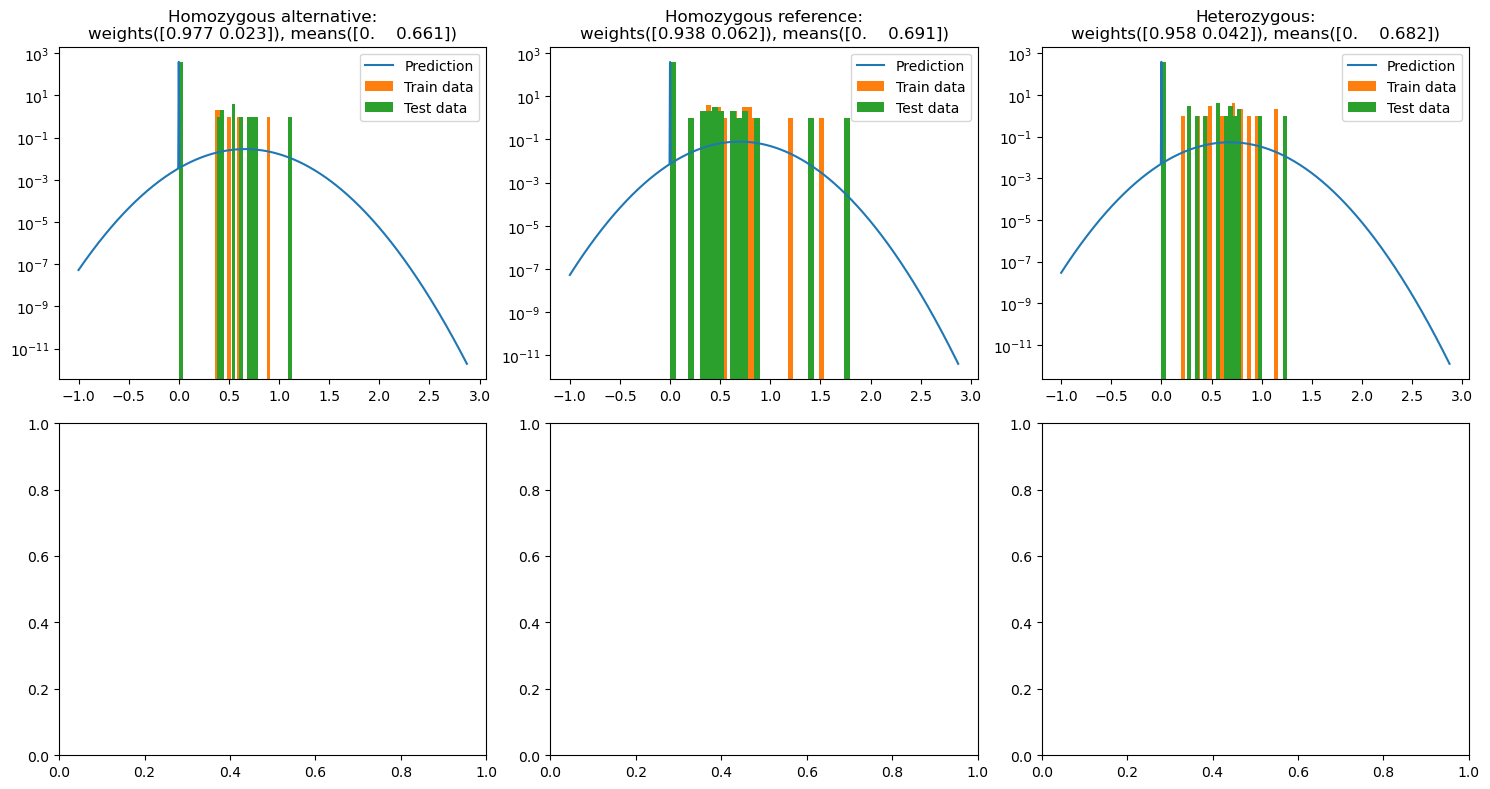

In [27]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(15, 4*2)

for i, sample in tqdm(enumerate(all_model_data.keys())): # sample 'snp_cell type'
    train_x, train_y, val_x, val_y, test_x, test_y = all_model_data[sample]
    train_one_gene(train_x, train_y,
                   test_x, test_y, ax[i])
plt.tight_layout()
plt.savefig('figures/gausmix_tfs_log.png', dpi=300)

Plot normal scale

In [ ]:
fig, ax = plt.subplots(n_tops, 3)
fig.set_size_inches(15,4*n_tops)

for i, sample in tqdm(enumerate(all_model_data.keys())): # sample 'snp_cell type'
    train_x, train_y, val_x, val_y, test_x, test_y = all_model_data[sample]
    train_one_gene(train_x, train_y,
                   test_x, test_y, ax[i],
                  log=False)
plt.tight_layout()
plt.savefig('figures/gausmix_tfs.png', dpi=300)